In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load the Data

In [2]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(329, 20530)
(83, 20530)
(329,)
(83,)


## Standardize the Data

In [3]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[-0.48855657  0.12112708 -0.33372349 ...  0.04735987  0.50779996
  -0.02217494]
 [ 0.83092164  1.17948768 -0.33372349 ...  0.18754437  0.77965228
  -0.17205193]
 [-1.861054   -0.69352094 -0.33372349 ... -0.35346398 -2.00005787
   3.63814136]
 ...
 [ 1.50287947  0.88173571  0.1048791  ... -0.33180584  0.91213697
  -0.14253948]
 [-0.06583194  0.60359346 -0.33372349 ...  0.20030191  0.44110666
  -1.31512921]
 [-0.87784052 -0.01478846 -0.33372349 ...  0.12805867  1.46177518
  -0.6430939 ]]


# Keeping 99% of variance
Let's first test how many components we need to keep 99% of variance.

In [22]:
from sklearn.decomposition import PCA
import pandas as pd

# Initialize PCA with n_components=0.99
pca = PCA(n_components=0.99)

reduced_X_train = pca.fit_transform(X_train)

selected_components = pca.n_components_
print(f"Number of components selected to explain 99% of variance: {selected_components}")

Number of components selected to explain 99% of variance: 308


In [23]:
reduced_X_train.shape

(329, 308)

In [24]:
X_test.shape

(83, 20530)

In [25]:
reduced_X_test = pca.transform(X_test)

reduced_X_test.shape

(83, 308)

### Exhausive search for finding the best parameters for SVM model

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
parameters = [
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['sigmoid'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['linear']},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['poly'], 'degree': [2, 3, 4, 5]}
            ]

# Create a GridSearchCV object
search = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=2, cv=3)

# Fit the grid search to the data
search.fit(reduced_X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                          'kernel': ['sigmoid']},
                         {'C': [0.1, 1, 10, 100, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 100], 'degree': [2, 3, 4, 5],
                          'kernel': ['poly']}],
             verbose=2)

In [34]:
best_params = search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}


In [35]:
best_model = search.best_estimator_
best_model

SVC(C=0.1, kernel='linear', probability=True)

In [36]:
search.cv_results_

{'mean_fit_time': array([0.00953778, 0.00818348, 0.00987021, 0.00748976, 0.01133537,
        0.01415833, 0.00903304, 0.00887664, 0.00824563, 0.00686383,
        0.00699973, 0.00896327, 0.00678666, 0.00834894, 0.00918508,
        0.00835013, 0.00817712, 0.00717696, 0.00835148, 0.00751495,
        0.00735593, 0.00567174, 0.00822083, 0.00787981, 0.00885614,
        0.00718641, 0.0063746 , 0.00650517, 0.00753649, 0.00806332,
        0.01318924, 0.01380086, 0.01404746, 0.01354663, 0.01391196,
        0.05241569, 0.05854615, 0.05535269, 0.05456734, 0.05201332,
        0.0959053 , 0.06718016, 0.05323315, 0.05255437, 0.05232143,
        0.05823787, 0.0535574 , 0.0537343 , 0.05706453, 0.05134535,
        0.05134273, 0.05390024, 0.06303533, 0.05352084, 0.04905804,
        0.05555614, 0.05522895, 0.05223274, 0.05639752, 0.05641023,
        0.05240266, 0.05189212, 0.05423021, 0.05290135, 0.05299743,
        0.05256176, 0.05423713, 0.05220421, 0.05256248, 0.05607231,
        0.05941455, 0.05273573,

In [37]:
best_score = search.best_score_     # this is accuracy score
print("Best Score:", best_score)    

Best Score: 0.9392549346677788


In [38]:
from sklearn.metrics import accuracy_score

y_pred_test = best_model.predict(reduced_X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", test_accuracy)

Test Set Accuracy: 0.9156626506024096


In [39]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.8526119402985075


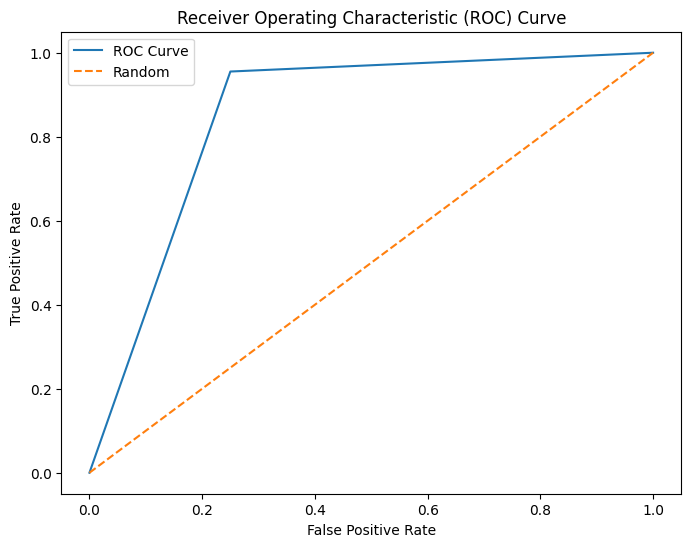

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

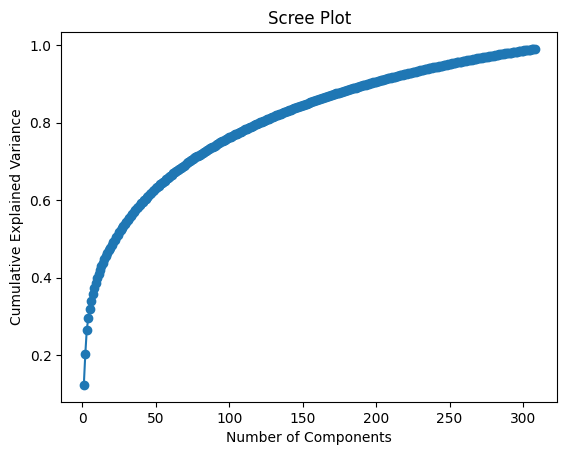

In [41]:
# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

# Experimenting with the number of components to keep
Now let's experiment with the number of components to find how many components we need to keep to get the best accuracy.

### n_components = 50, 100, 150, ..., 300

In [23]:
from sklearn.metrics import roc_auc_score

test_accuracy_list = []
auc_score_list = []

for n_components in range(50, 300, 50):
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    model = SVC(C=1, kernel='linear', probability=True)
    model.fit(reduced_X_train, y_train)
    y_pred_test = model.predict(reduced_X_test)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    print(f"n_components: {n_components}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

n_components: 50, Test Set Accuracy: 0.891566265060241, AUC Score: 0.8138992537313432

n_components: 100, Test Set Accuracy: 0.891566265060241, AUC Score: 0.8138992537313432

n_components: 150, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8451492537313433

n_components: 200, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8526119402985075

n_components: 250, Test Set Accuracy: 0.9036144578313253, AUC Score: 0.8213619402985075



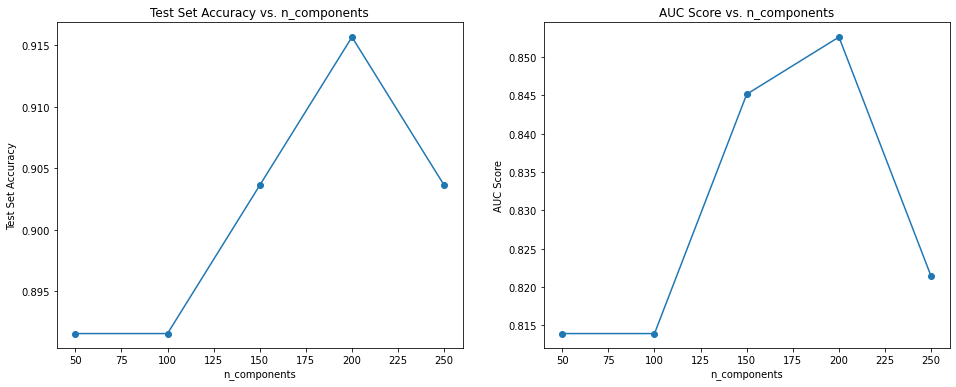

In [26]:
# plot two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# plot test accuracy
ax[0].plot(range(50, 300, 50), test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

# plot auc score
ax[1].plot(range(50, 300, 50), auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

Let's find on a more granular level.
### n_components = 150 to 329

[Note : PCA has to be applied within the dim of min(num_samples, num_features) and here 329 samples and 20530 features]

In [43]:
from sklearn.metrics import roc_auc_score

train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_acc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

parameters = [
                # {'C': [0.1, 1, 10, 100, 100], 'kernel': ['precomputed']},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['linear']},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['poly'], 'degree': [2, 3, 4, 5]},
                {'C': [0.1, 1, 10, 100, 100], 'kernel': ['sigmoid'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
            ]

for n_components in range(10, X_train.shape[0]):
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    search = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=2, cv=3)
    search.fit(reduced_X_train, y_train)
    model = search.best_estimator_

    train_accuracy = search.best_score_
    test_accuracy = search.score(reduced_X_test, y_test)
    y_pred_test = model.predict(reduced_X_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    # for saving the best model
    if test_accuracy > max_acc:
        max_acc = test_accuracy
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred_test

    print(f"n_components: {n_components}, Train Set Accuracy: {train_accuracy}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_components: 10, Train Set Accuracy: 0.9392271337225466, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_components: 11, Train Set Accuracy: 0.9361968306922436, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_components: 12, Train Set Accuracy: 0.94837364470392, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_components: 13, Train Set Accuracy: 0.9453433416736168, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_components: 14, Train Set Accuracy: 0.9392549346677788, Test Set Accuracy: 0.927710843373494, AUC Score: 0.8600746268656717

Fitting 3 folds for each of 100 candidates, tota

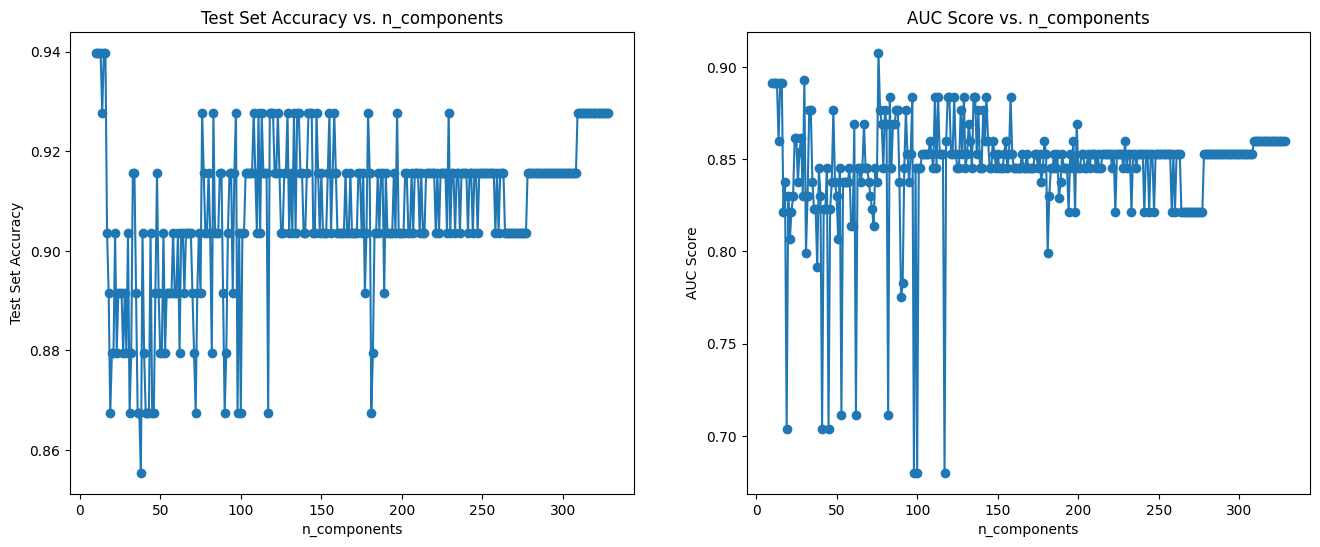

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(range(10, X_train.shape[0]), test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

ax[1].plot(range(10, X_train.shape[0]), auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

In [60]:
print("Best Test Set Accuracy:", max_acc)
print("Best n_components:", optimal_n_components)
print("auc score:", auc_score_list[optimal_n_components - 10])

Best Test Set Accuracy: 0.9397590361445783
Best n_components: 10
auc score: 0.8913246268656716


In [1]:
# make a df containing n_components, train_accuracy, test_accuracy, auc_score
df = pd.DataFrame({'n_components': range(10, X_train.shape[0]), 'train_accuracy': train_accuracy_list, 'test_accuracy': test_accuracy_list, 'auc_score': auc_score_list})
df

NameError: name 'pd' is not defined

In [55]:
df.to_csv('pca_svm_results.csv', index=False)

In [57]:
# print the rows of top 10 test accuracy
df.sort_values(by='test_accuracy', ascending=False).head(10)

,n_components,train_accuracy,test_accuracy,auc_score
0,10,0.939227,0.939759,0.891325
2,12,0.948374,0.939759,0.891325
3,13,0.945343,0.939759,0.891325
1,11,0.936197,0.939759,0.891325
5,15,0.930108,0.939759,0.891325
6,16,0.936141,0.939759,0.891325
123,133,0.924048,0.927711,0.860075
148,158,0.899805,0.927711,0.883862
145,155,0.924159,0.927711,0.860075
137,147,0.908896,0.927711,0.860075


In [59]:
n_components = 10
pca = PCA(n_components=n_components)
reduced_X_train = pca.fit_transform(X_train)
reduced_X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Print the cumulative explained variance
print("Cumulative Explained Variance for the first 10 components:")
for i in range(n_components):
    print(f"Component {i + 1}: {cumulative_explained_variance[i]:.4f}")

[0.12344771 0.07923234 0.06248387 0.03010979 0.02487283 0.02066256
 0.0176553  0.0145658  0.01394022 0.01249782]
Cumulative Explained Variance for the first 10 components:
Component 1: 0.1234
Component 2: 0.2027
Component 3: 0.2652
Component 4: 0.2953
Component 5: 0.3201
Component 6: 0.3408
Component 7: 0.3585
Component 8: 0.3730
Component 9: 0.3870
Component 10: 0.3995


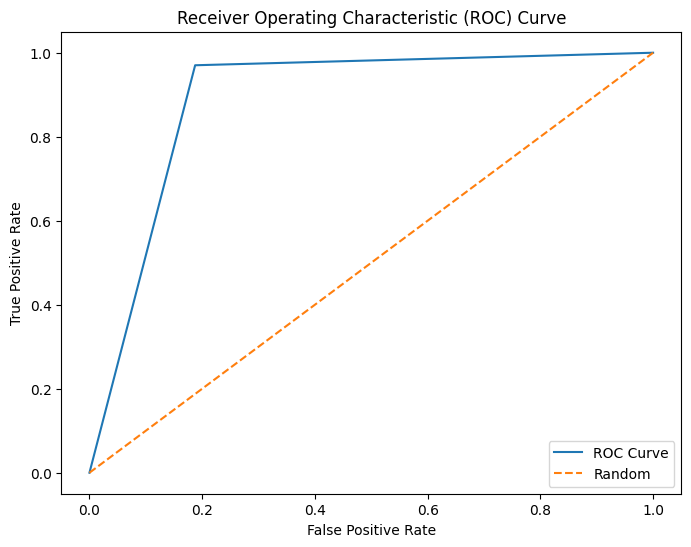

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, optimal_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, optimal_predictions))
print()

print(classification_report(y_test, optimal_predictions))

[[13  3]
 [ 2 65]]

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.96      0.97      0.96        67

    accuracy                           0.94        83
   macro avg       0.91      0.89      0.90        83
weighted avg       0.94      0.94      0.94        83



In [63]:
import pickle

dict = {
    'Model': optimal_model,
    'n_components': optimal_n_components,
    'x_train': optimal_x_train,
    'x_test': optimal_x_test,
    'predictions': optimal_predictions,
    'Test Accuracy': max_acc,
    'AUC_score': auc_score_list[optimal_n_components - 150]
}

with open('SVM_PCA.pkl', 'wb') as file:
    pickle.dump(dict, file)

## Load to verify

In [66]:
dct = pickle.load(open('SVM_PCA.pkl', 'rb'))
X_test = dct['x_test']
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_test = dct['Model'].predict(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
auc_score = roc_auc_score(y_test, y_pred_test)

print("Test Accuracy: ", acc_score)
print("AUC Score: ", auc_score)

Test Accuracy:  0.9397590361445783
AUC Score:  0.8913246268656716
